In [1]:
import os
from PIL import Image, ImageOps
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn import neural_network
from sklearn import linear_model
import matplotlib.pyplot as plt

In [7]:
def plot_samples(inputs, outputs, outputNames, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(inputs[i])  # Nu specifica cmap pentru a păstra culorile originale
        ax.set_title(f"Label: {outputNames[outputs[i]]}")

    plt.show()

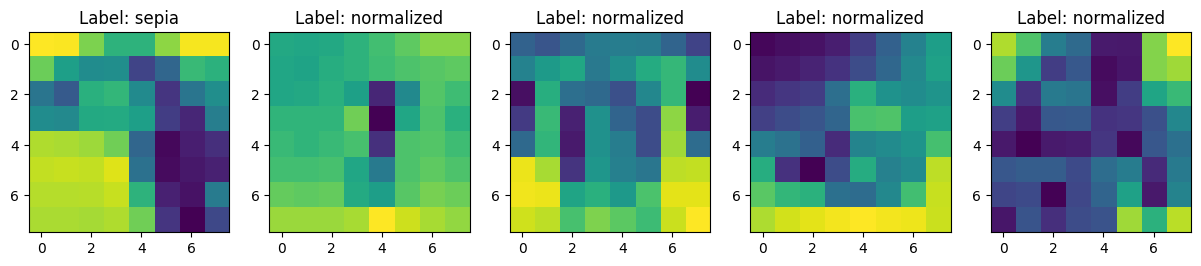

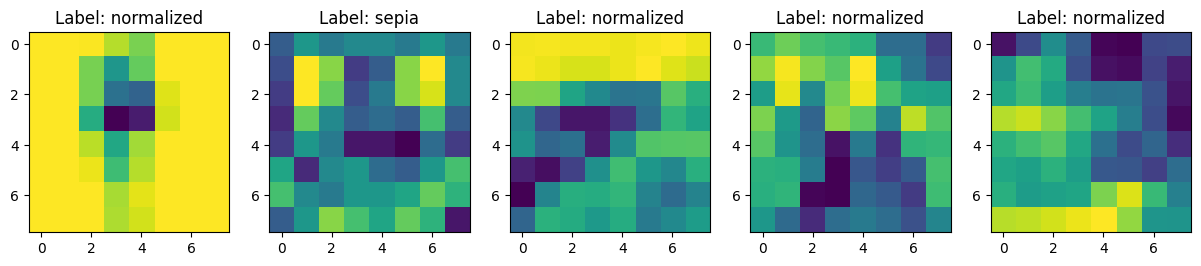

In [73]:
def load_images_from_folders(normalized_folder, sepia_folder):
    inputs = []
    outputs = []
    outputNames = ['normalized', 'sepia']
    # Normlizate
    for filename in os.listdir(normalized_folder):
        if filename.endswith('.jpg') and 'normalized' in filename:
            img = Image.open(os.path.join(normalized_folder, filename)).resize((8, 8)).convert('L') # gri
            
            # img_path = os.path.join(normalized_folder, filename)
            # img = Image.open(img_path)
            # img = img.resize(image_size)  # redimensionare
            img_array = np.array(img) / 16.0
            inputs.append(np.array(img_array))
            outputs.append(0)  # Eticheta pentru imagini normalizate

    # Sepia
    for filename in os.listdir(sepia_folder):
        if filename.endswith('.jpg') and 'sepia' in filename:
            img = Image.open(os.path.join(sepia_folder, filename)).resize((8, 8)).convert('L') # gri

            
            # img_path = os.path.join(sepia_folder, filename)
            # img = Image.open(img_path)
            # img = img.resize(image_size)  # redimensionare
            # img = img.convert('RGB')

            img_array = np.array(img) / 16.0
            inputs.append(np.array(img_array))
            outputs.append(1)  # Eticheta pentru imagini cu sepia


    noData = len(inputs)
    permutation = np.random.permutation(noData)
    inputs = np.array(inputs)[permutation]
    outputs = np.array(outputs)[permutation]
    
    return inputs, outputs, outputNames

normalized_folder = 'D:/FACULTATE/SEM4/AI/Lab7/img_normalizate'
sepia_folder = 'D:/FACULTATE/SEM4/AI/Lab7/img_sepia'

inputs, outputs, outputNames = load_images_from_folders(normalized_folder, sepia_folder)

plot_samples(inputs[:5], outputs[:5], outputNames[:5])
plot_samples(inputs[-5:], outputs[-5:], outputNames[-5:])

In [65]:
def splitData(input_data, output_data):
    np.random.seed(5)
    indexes = [i for i in range(len(inputs))]
    trainSample = np.random.choice(indexes, int(0.8 * len(inputs)), replace = False)
    testSample = [i for i in indexes  if not i in trainSample]

    trainInputs = [inputs[i] for i in trainSample]
    trainOutputs = [outputs[i] for i in trainSample]
    testInputs = [inputs[i] for i in testSample]
    testOutputs = [outputs[i] for i in testSample]

    return trainInputs, trainOutputs, testInputs, testOutputs

In [66]:
def data2FeaturesMoreClasses(inputs, outputs):
    labels = set(outputs)
    noData = len(inputs)
    for crtLabel in labels:
        x = [inputs[i][0] for i in range(noData) if outputs[i] == crtLabel ]
        y = [inputs[i][1] for i in range(noData) if outputs[i] == crtLabel ]
        plt.scatter(x, y, label = outputNames[crtLabel])
    plt.xlabel('feat1')
    plt.ylabel('feat2')
    plt.legend()
    plt.show() 

In [67]:
def normalisation(trainData, testData):
    scaler = StandardScaler()
    if not isinstance(trainData[0], list):
        # encode each sample into a list
        trainData = [[d] for d in trainData]
        testData = [[d] for d in testData]

        scaler.fit(trainData)  # fit only on training data
        normalisedTrainData = scaler.transform(trainData)  # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data

        # decode from list to raw values
        normalisedTrainData = [el[0] for el in normalisedTrainData]
        normalisedTestData = [el[0] for el in normalisedTestData]
    else:
        scaler.fit(trainData)  # fit only on training data
        normalisedTrainData = scaler.transform(trainData)  # apply same transformation to train data
        normalisedTestData = scaler.transform(testData)  # apply same transformation to test data
    return normalisedTrainData, normalisedTestData

In [68]:
def flatten(mat):
    x = []
    for line in mat:
        for el in line:
            x.append(el)
    return x

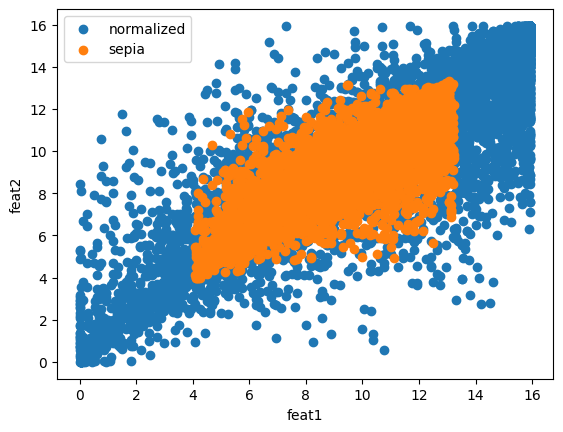

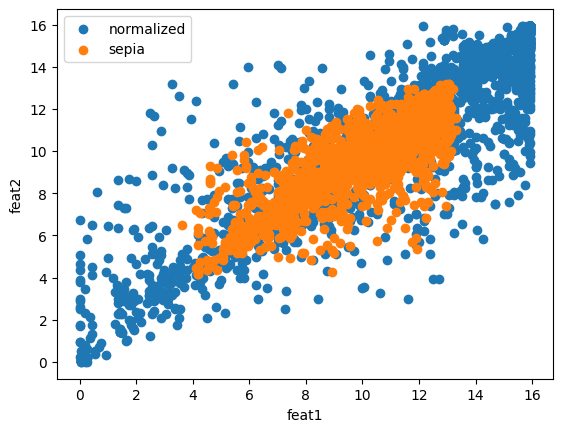

In [74]:
trainInputs, trainOutputs, testInputs, testOutputs = splitData(inputs, outputs)
#train data
data2FeaturesMoreClasses(trainInputs, trainOutputs)
#test data
data2FeaturesMoreClasses(testInputs, testOutputs)

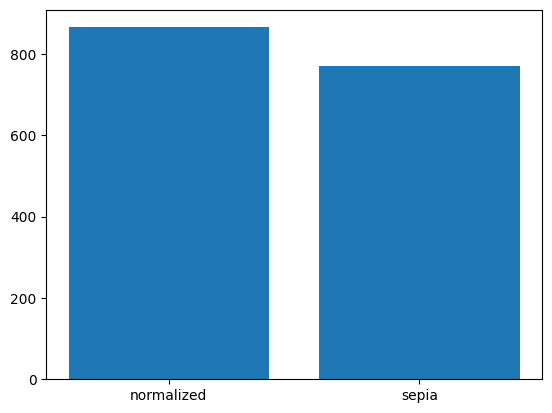

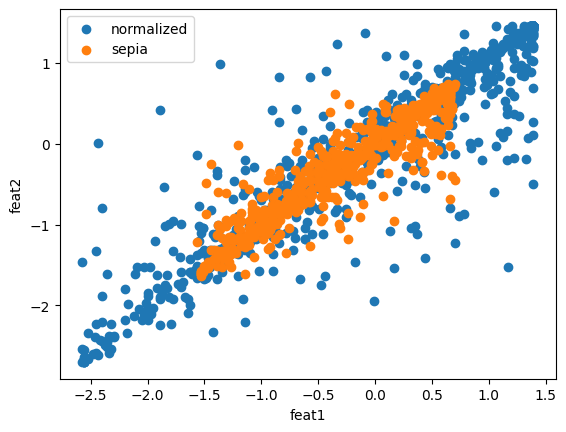

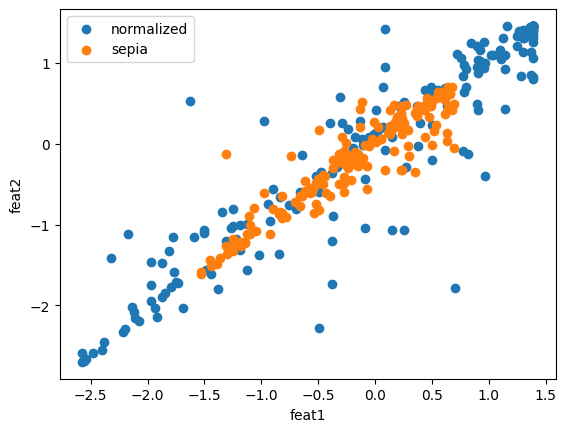

In [75]:
bins = range(len(outputNames) + 1)
plt.hist(trainOutputs, bins, rwidth=0.8)
bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
plt.xticks(np.arange(min(bins) + bin_w / 2, max(bins), bin_w), outputNames)
plt.show()

trainInputsFlatten = [flatten(el) for el in trainInputs]
testInputsFlatten = [flatten(el) for el in testInputs]
#
trainInputsNormalised, testInputsNormalised = normalisation(trainInputsFlatten, testInputsFlatten)

#train data normalizat
data2FeaturesMoreClasses(trainInputsNormalised, trainOutputs)
#test data noralizat
data2FeaturesMoreClasses(testInputsNormalised, testOutputs)

In [76]:
def evalMultiClass(realLabels, computedLabels, labelNames):
    from sklearn.metrics import confusion_matrix

    confMatrix = confusion_matrix(realLabels, computedLabels)
    acc = sum([confMatrix[i][i] for i in range(len(labelNames))]) / len(realLabels)
    precision = {}
    recall = {}
    for i in range(len(labelNames)):
        precision[labelNames[i]] = confMatrix[i][i] / sum([confMatrix[j][i] for j in range(len(labelNames))])
        recall[labelNames[i]] = confMatrix[i][i] / sum([confMatrix[i][j] for j in range(len(labelNames))])
    return acc, precision, recall, confMatrix

In [99]:
def plotConfusionMatrix(cm, classNames, title):
    from sklearn.metrics import confusion_matrix
    import itertools

    classes = classNames
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix ' + title)
    plt.colorbar()
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    text_format = 'd'
    thresh = cm.max() / 2.
    for row, column in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(column, row, format(cm[row, column], text_format),
                 horizontalalignment='center',
                color='black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

Iteration 1, loss = 0.73669391
Iteration 2, loss = 0.65759118
Iteration 3, loss = 0.60925506
Iteration 4, loss = 0.57478004
Iteration 5, loss = 0.55026661
Iteration 6, loss = 0.52384361
Iteration 7, loss = 0.49466670
Iteration 8, loss = 0.47041551
Iteration 9, loss = 0.45204598
Iteration 10, loss = 0.43423786
Iteration 11, loss = 0.42163728
Iteration 12, loss = 0.40883950
Iteration 13, loss = 0.39736238
Iteration 14, loss = 0.38549419
Iteration 15, loss = 0.38801714
Iteration 16, loss = 0.38116904
Iteration 17, loss = 0.38086971
Iteration 18, loss = 0.36705637
Iteration 19, loss = 0.35987659
Iteration 20, loss = 0.35584762
Iteration 21, loss = 0.35144137
Iteration 22, loss = 0.34355134
Iteration 23, loss = 0.34648953
Iteration 24, loss = 0.34132576
Iteration 25, loss = 0.33283841
Iteration 26, loss = 0.33955233
Iteration 27, loss = 0.32452853
Iteration 28, loss = 0.33332131
Iteration 29, loss = 0.32366993
Iteration 30, loss = 0.32050969
Iteration 31, loss = 0.31282567
Iteration 32, los

C:\Users\ariis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


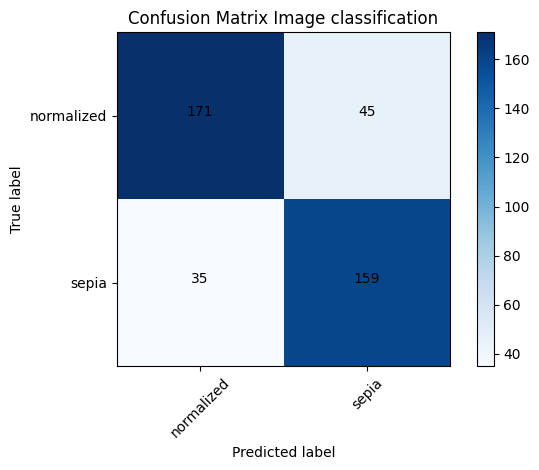

acc:  0.8048780487804879
precision:  {'normalized': 0.8300970873786407, 'sepia': 0.7794117647058824}
recall:  {'normalized': 0.7916666666666666, 'sepia': 0.8195876288659794}


In [100]:
    # Create and train the classifier
classifier = neural_network.MLPClassifier(hidden_layer_sizes=(5,), activation='relu', max_iter=100, solver='sgd', verbose=10, random_state=1, learning_rate_init=.10)

classifier.fit(trainInputsNormalised, trainOutputs)
    # Predict the labels
predictedLabels = classifier.predict(testInputsNormalised)
    # Evaluate the model
acc, prec, recall, cm = evalMultiClass(testOutputs, predictedLabels, outputNames)

    # Plot the results
plotConfusionMatrix(cm, outputNames, "Image classification")
    print('acc: ', acc)
    print('precision: ', prec)
    print('recall: ', recall)

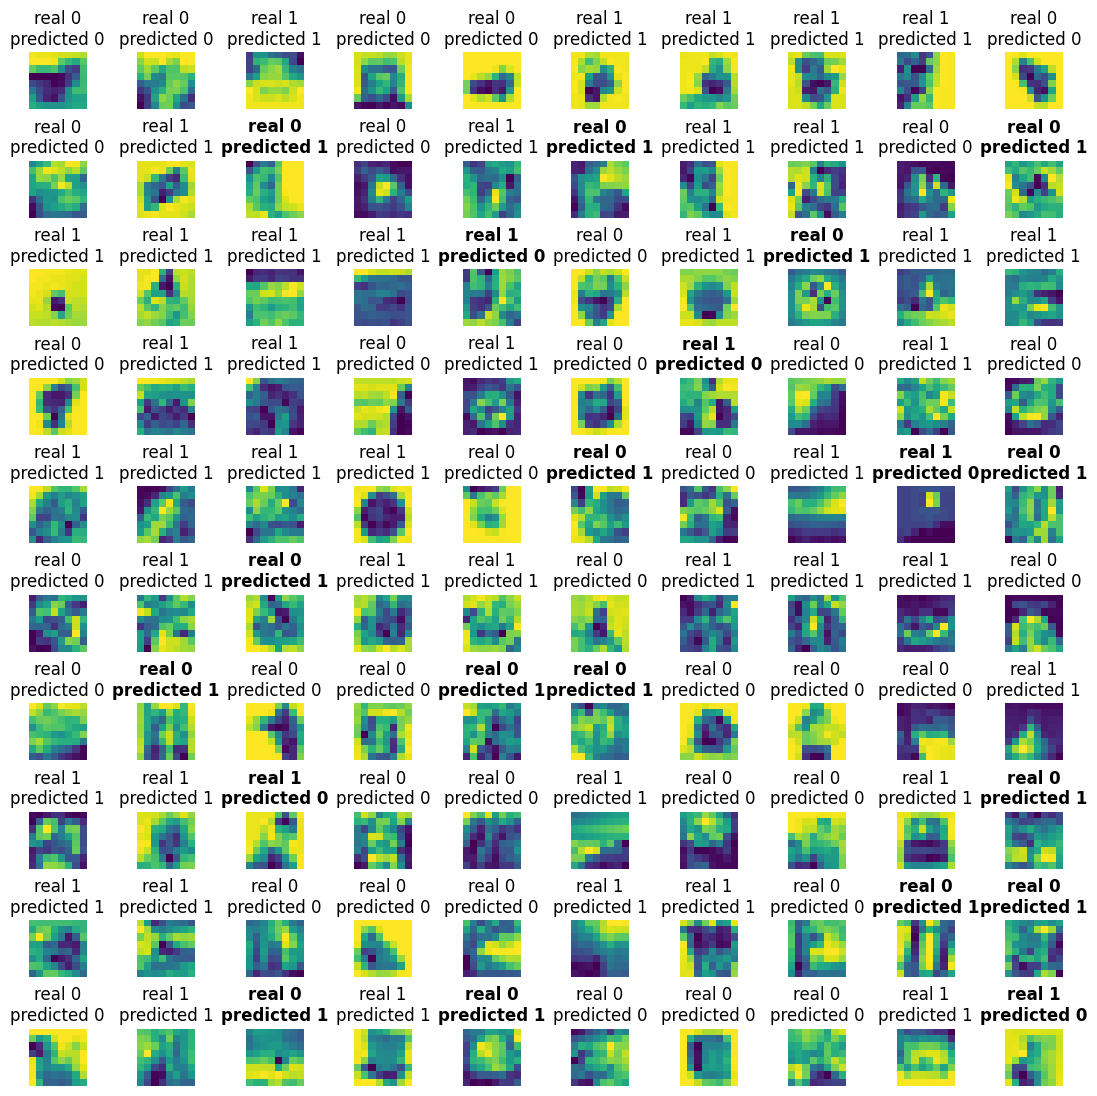

In [79]:
n = 10
m = 10
fig, axes = plt.subplots(n, m, figsize=(11, 11))
fig.tight_layout()
for i in range(0, n):
    for j in range(0, m):
        axes[i][j].imshow(testInputs[m * i + j])
        if (testOutputs[m * i + j] == predictedLabels[m * i + j]):
            font = 'normal'
        else:
            font = 'bold'
        axes[i][j].set_title(
            'real ' + str(testOutputs[m * i + j]) + '\npredicted ' + str(predictedLabels[m * i + j]),fontweight=font)
        axes[i][j].set_axis_off()
plt.show()

In [ ]:
# optimizare (hyper)parametri

C:\Users\ariis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layer Sizes: (100,)
Accuracy: 0.5219512195121951
Precision: 0.5170731707317073
Recall: 0.5221674876847291
Confusion Matrix:
[[108  99]
 [ 97 106]]



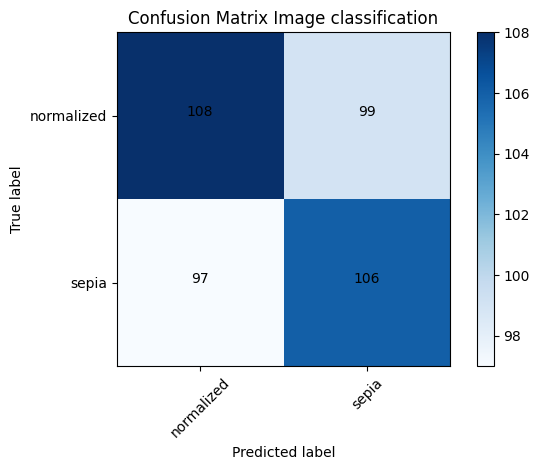

C:\Users\ariis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Hidden Layer Sizes: (50, 50)
Accuracy: 0.5439024390243903
Precision: 0.5392156862745098
Recall: 0.541871921182266
Confusion Matrix:
[[113  94]
 [ 93 110]]



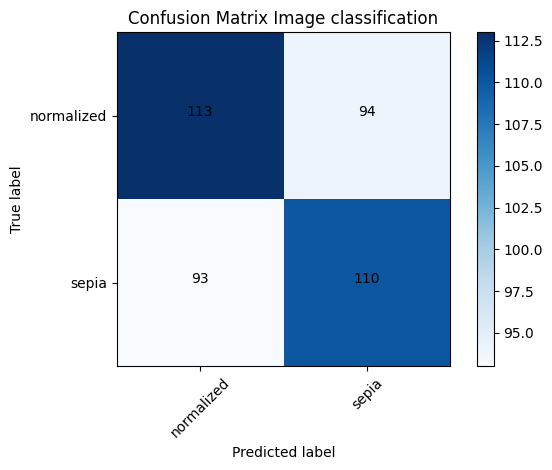

Hidden Layer Sizes: (100, 50, 25)
Accuracy: 0.526829268292683
Precision: 0.5238095238095238
Recall: 0.4876847290640394
Confusion Matrix:
[[117  90]
 [104  99]]



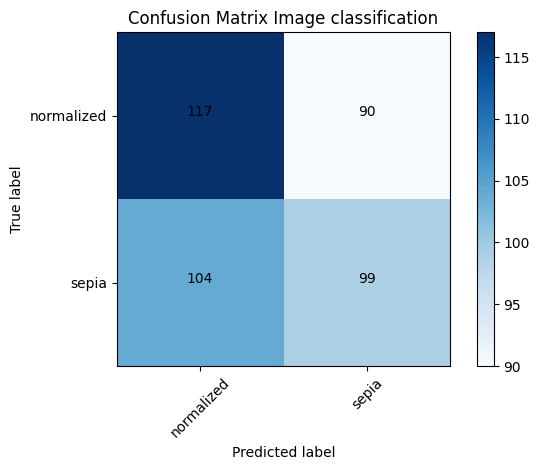

In [101]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

train_inputs, test_inputs, train_outputs, test_outputs = train_test_split(inputs, outputs, test_size=0.2,random_state=42)

# 3 modalitati de a definii hidden layers:
# (100,) - un strat ascuns cu 100 de neuroni
# (50, 50) - 2 straturi ascunse
# (100, 50, 25) 
hidden_layer_sizes_options = [(100,), (50, 50), (100, 50, 25)]

for hidden_layer_sizes in hidden_layer_sizes_options:
    classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation='relu', max_iter=200, solver='adam', random_state=1)
    classifier.fit(trainInputsNormalised, trainOutputs)

    predicted_labels = classifier.predict(testInputsNormalised)

    accuracy = accuracy_score(test_outputs, predicted_labels)
    precision = precision_score(test_outputs, predicted_labels, pos_label=1)
    recall = recall_score(test_outputs, predicted_labels, pos_label=1)
    confusion_mat = confusion_matrix(test_outputs, predicted_labels)

    print(f"Hidden Layer Sizes: {hidden_layer_sizes}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Confusion Matrix:\n{confusion_mat}\n")
    
    plotConfusionMatrix(confusion_mat, outputNames, "Image classification")